# Titanic Dataset - Your first teacher

In [106]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Import data

In [133]:
# read data
df = pd.read_csv('train.csv')


# separate columns to Num and Cat
TARGET_VAR = 'Survived'
NUM_FEAT = ['Age', 'SibSp', 'Parch', 'Fare']
CAT_FEAT = ['Pclass', 'Sex', 'Embarked']
OTHERS = ['Name', 'Cabin'] # Luxury

# Concerns:
# Age - some null values may need mean imputation --> can we impute within classes for better accuracy???
# Cabin - many nulls, but surely is important let's see what we can do 

# datatypes
for cat in CAT_FEAT:
    df[cat] = df[cat].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    category
 3   Name         891 non-null    object  
 4   Sex          891 non-null    category
 5   Age          714 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    float64 
 10  Cabin        204 non-null    object  
 11  Embarked     889 non-null    category
dtypes: category(3), float64(2), int64(4), object(3)
memory usage: 65.8+ KB


### grouping of features

Index
* PassengerId - just an index

Target Variable
* Survived - 0 = died, 1 = survived

Physical Features (Estimated impact S,M,L)
* Name (S) - needs text feature processing
* Sex (L)
* Age (L)
* SibSp (M)
* Parch (M)

Titanic Features
* Pclass (L)
* Ticket (S) - ticket number, should not impact much
* Fare (S)
* Cabin (M) - Position on the cabin will be important can be closer to the sinking point
* Embarked (S)

In [134]:
display(df[NUM_FEAT].describe())
display(df[CAT_FEAT].describe(include='all'))

,Age,SibSp,Parch,Fare
count,714.000000,891.000000,891.000000,891.000000
mean,29.699118,0.523008,0.381594,32.204208
std,14.526497,1.102743,0.806057,49.693429
min,0.420000,0.000000,0.000000,0.000000
25%,20.125000,0.000000,0.000000,7.910400
50%,28.000000,0.000000,0.000000,14.454200
75%,38.000000,1.000000,0.000000,31.000000
max,80.000000,8.000000,6.000000,512.329200


,Pclass,Sex,Embarked
count,891,891,889
unique,3,2,3
top,3,male,S
freq,491,577,644


## EDA

0    549
1    342
Name: Survived, dtype: int64

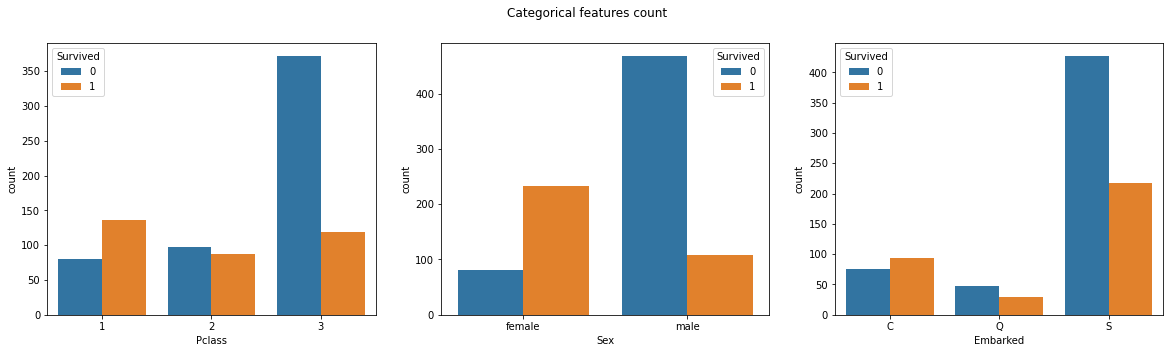

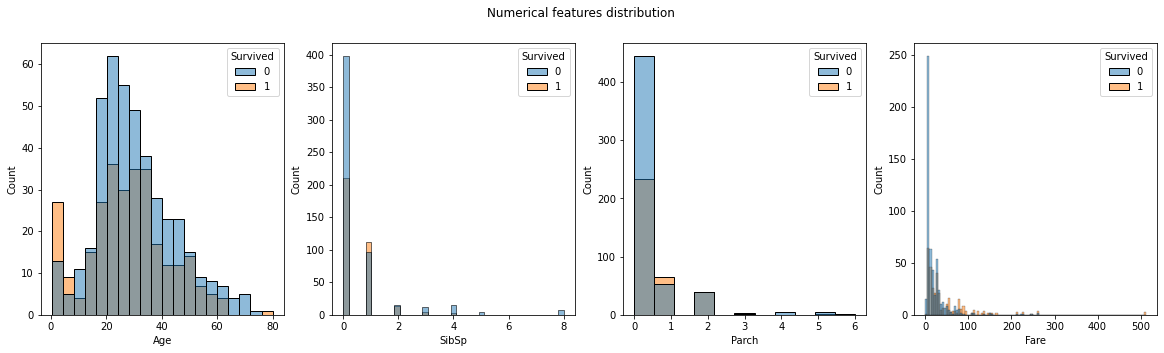

In [135]:
def examine_df(df):
    '''
    Examines the df
    - count instances of each target variable
    - count instances of each target variable with respect to categorical features
    - plot histograms of numerical features
    '''
    # count target var
    display(df[TARGET_VAR].value_counts())

    # cat features
    fig, ax = plt.subplots(1,len(CAT_FEAT),figsize=(20,5))
    for i in range(len(CAT_FEAT)):
        sns.countplot(ax=ax[i], data=df, x=CAT_FEAT[i], hue=TARGET_VAR)
    fig.suptitle('Categorical features count')
    plt.show()

    # num feat
    fig, ax = plt.subplots(1,len(NUM_FEAT),figsize=(20,5))
    for i in range(len(NUM_FEAT)):
        sns.histplot(ax=ax[i], data=df, x=NUM_FEAT[i], hue=TARGET_VAR)
    fig.suptitle('Numerical features distribution')
    plt.show()

examine_df(df)
# PClass - first class got > 0.5 survival rate, 3rd class died way more
# Sex - male died more
# Embarked - most were out of S port
# All except age are kind of exponentially distributed
# Age is kind of a skewed normal


## Cleaning

Deal with missing values
* Numerical --> Median imputation
* Categorical --> replace with mode

In [136]:
# numerical
print('Age - Before')
display(df['Age'].describe())

print('\nAge - After')
df['Age'].fillna(df['Age'].median(), inplace=True)
display(df['Age'].describe())

Age - Before


count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64


Age - After


count    891.000000
mean      29.361582
std       13.019697
min        0.420000
25%       22.000000
50%       28.000000
75%       35.000000
max       80.000000
Name: Age, dtype: float64

In [137]:
# cat
print('Embarked - Before')
display(df['Embarked'].describe())

print('\nEmbarked - After')
df['Embarked'].fillna(df['Embarked'].value_counts().sort_values(ascending=False).index[0], inplace=True)
display(df['Embarked'].describe())

Embarked - Before


count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object


Embarked - After


count     891
unique      3
top         S
freq      646
Name: Embarked, dtype: object

In [138]:
# train test split
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.1, random_state=69)

# separate features and target variables
X_train_num, X_train_cat, y_train = df_train[NUM_FEAT], df_train[CAT_FEAT], df_train[TARGET_VAR]
X_test_num, X_test_cat, y_test = df_test[NUM_FEAT], df_test[CAT_FEAT], df_test[TARGET_VAR]

0    490
1    311
Name: Survived, dtype: int64

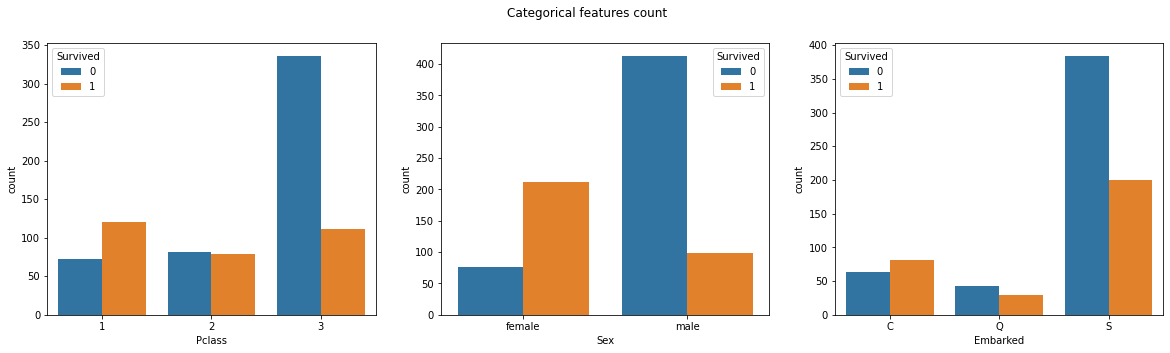

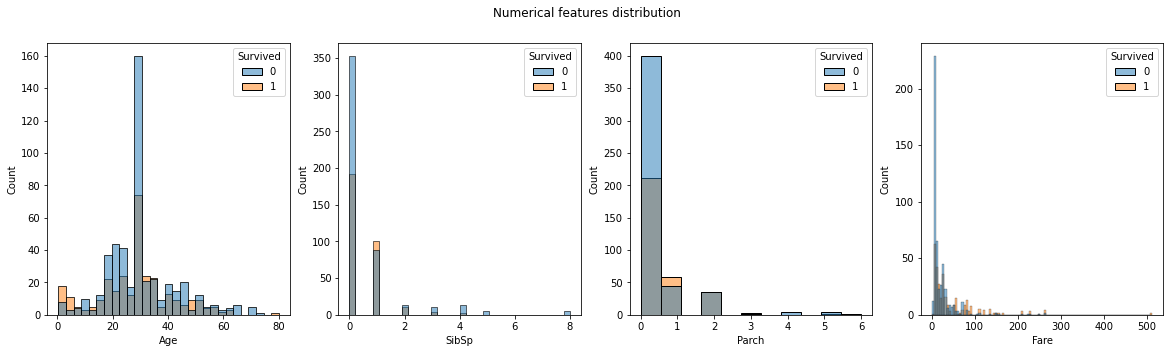

0    59
1    31
Name: Survived, dtype: int64

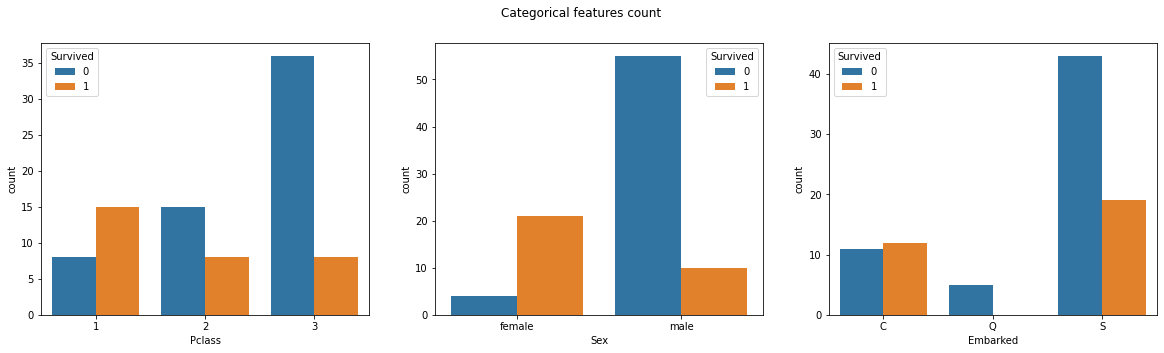

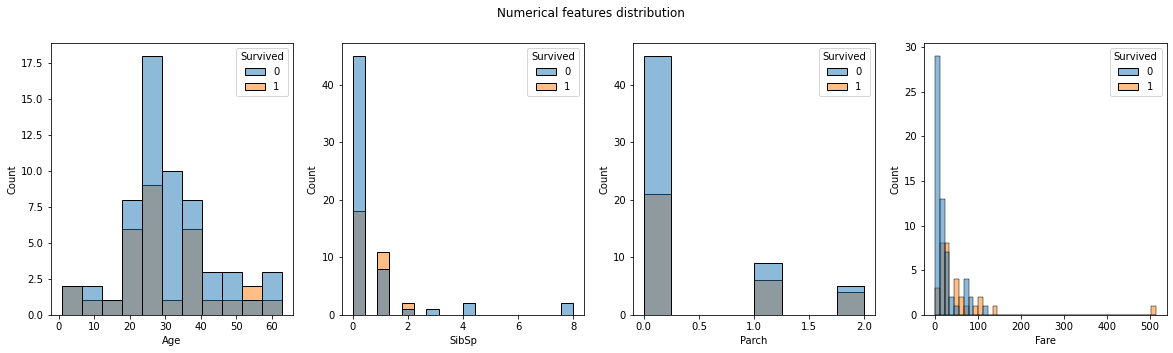

In [139]:
# check training data 
examine_df(df_train)
examine_df(df_test)

## First pass simple model with numerical features only

performance metrics
* accuracy
* confusion matrix - precision, recall, f1
* ROC&AUC
* logloss 

what does each metric tell us and what should we care the most????
https://www.kdnuggets.com/2020/04/performance-evaluation-metrics-classification.html

DUMB MODEL = saying that all are dead will get an accuracy of ~66% (59/90 ppl died in the test set)

In [119]:
# import metrics
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix, plot_roc_curve, log_loss

def evaluate_cf(cf, X_train, y_train, X_test, y_test):
    # fit and predict
    cf.fit(X_train, y_train)
    y_pred = cf.predict(X_test)

    # metrics
    print('Accuracy = {}'.format(accuracy_score(y_test, y_pred)))
    print('Logloss = {}'.format(log_loss(y_test, y_pred)))
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(cf, X_test, y_test)
    plot_roc_curve(cf, X_test, y_test)


Accuracy = 0.7
Logloss = 10.361686224968551
              precision    recall  f1-score   support

           0       0.72      0.90      0.80        59
           1       0.62      0.32      0.43        31

    accuracy                           0.70        90
   macro avg       0.67      0.61      0.61        90
weighted avg       0.68      0.70      0.67        90



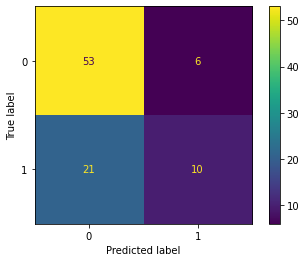

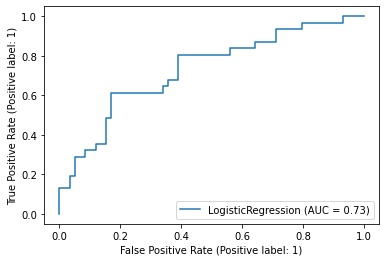

In [120]:
# logistic regression basic model
from sklearn.linear_model import LogisticRegression

evaluate_cf(LogisticRegression(), X_train_num, y_train, X_test_num, y_test)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression', LogisticRegression())])
Accuracy = 0.7
Logloss = 10.361650687304987
              precision    recall  f1-score   support

           0       0.70      0.97      0.81        59
           1       0.75      0.19      0.31        31

    accuracy                           0.70        90
   macro avg       0.72      0.58      0.56        90
weighted avg       0.71      0.70      0.64        90



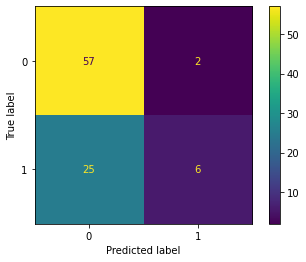

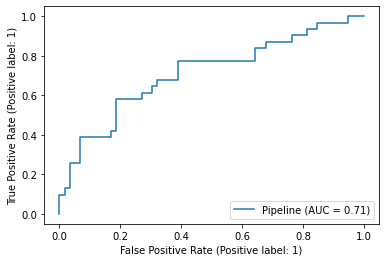

In [121]:
# experiment on scalers
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, RobustScaler, PowerTransformer

scalers = [StandardScaler(), MinMaxScaler(), Normalizer(), RobustScaler(), PowerTransformer()]
pls = [make_pipeline(s, LogisticRegression()) for s in scalers]

for pl in pls:
    # print(pl)
    pl.fit(X_train_num, y_train)
    y_pred = pl.predict(X_test_num)
    # print('Accuracy = {}'.format(accuracy_score(y_test, y_pred)))
    # print(classification_report(y_test, y_pred))

# no improvement on accuracy
# but minmax_scaler got better recall for 0
print(pls[1])
evaluate_cf(pls[1], X_train_num, y_train, X_test_num, y_test)


## Incorporate categorical variables into model

In [163]:
display(df_train.head(2))
display(df_test.head(2))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
378,379,0,3,"Betros, Mr. Tannous",male,20.0,0,0,2648,4.0125,NaN,C
332,333,0,1,"Graham, Mr. George Edward",male,38.0,0,1,PC 17582,153.4625,C91,S


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
205,206,0,3,"Strom, Miss. Telma Matilda",female,2.0,0,1,347054,10.4625,G6,S
696,697,0,3,"Kelly, Mr. James",male,44.0,0,0,363592,8.0500,NaN,S


In [178]:
# One hot encoding for all three cat features
# and combined with the scaled num features
X_train_cat_enc = pd.get_dummies(X_train_cat, drop_first=True).reset_index(drop=True)
X_train_num_scld = pd.DataFrame(StandardScaler().fit_transform(X_train_num), columns=NUM_FEAT)
X_train = pd.concat([X_train_num_scld, X_train_cat_enc], axis=1)
display(X_train.head(2))

# do the same for X_test
X_test_cat_enc = pd.get_dummies(X_test_cat, drop_first=True).reset_index(drop=True)
X_test_num_scld = pd.DataFrame(StandardScaler().fit_transform(X_test_num), columns=NUM_FEAT)
X_test = pd.concat([ X_test_num_scld, X_test_cat_enc], axis=1)
display(X_test.head(2))


,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
0,-0.710373,-0.484375,-0.467081,-0.577033,0,1,1,0,0
1,0.670173,-0.484375,0.751590,2.499267,0,0,1,0,1


,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
0,-2.216325,-0.42045,0.963338,-0.396368,0,1,0,0,1
1,1.079067,-0.42045,-0.557722,-0.437665,0,1,1,0,1


Accuracy = 0.8444444444444444
Logloss = 5.372751856814786
              precision    recall  f1-score   support

           0       0.87      0.90      0.88        59
           1       0.79      0.74      0.77        31

    accuracy                           0.84        90
   macro avg       0.83      0.82      0.82        90
weighted avg       0.84      0.84      0.84        90



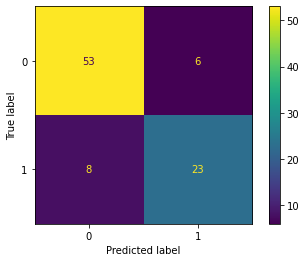

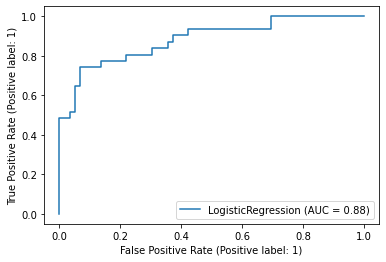

In [179]:
evaluate_cf(LogisticRegression(), X_train, y_train, X_test, y_test)